##**Setup Data**

In [ ]:
!pip install -q kaggle
from google.colab import files
#files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c comp-551-fall-2021

  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 54.1MB/s]
 94% 93.0M/99.0M [00:02<00:00, 24.4MB/s]
100% 99.0M/99.0M [00:03<00:00, 28.3MB/s]
 97% 193M/198M [00:05<00:00, 38.8MB/s]
100% 198M/198M [00:05<00:00, 34.8MB/s]
 94% 185M/197M [00:08<00:00, 17.4MB/s]
100% 197M/197M [00:08<00:00, 23.5MB/s]


In [ ]:
import os
import datetime

import zipfile
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
!mkdir ./train
!mkdir ./train/data
!mkdir ./train/labels

import zipfile
with zipfile.ZipFile('./images_l.pkl.zip', 'r') as train:
  train.extractall('./train/data')
with zipfile.ZipFile('./labels_l.pkl.zip', 'r') as labels:
  labels.extractall('./train/labels')

In [ ]:
!mkdir ./train/unlabeled

with zipfile.ZipFile('./images_ul.pkl.zip', 'r') as unlabeled:
  unlabeled.extractall('./train/unlabeled')

In [ ]:
!mkdir ./test
!mkdir ./test/data

with zipfile.ZipFile('./images_test.pkl.zip', 'r') as test:
  test.extractall('./test/data')

In [ ]:
IMAGE_SIZE = (56, 56)
BATCH_SIZE = 32
TRAIN_DATA_DIR = './train/data/images_l.pkl'
TRAIN_LABELS_DIR = './train/labels/labels_l.pkl'
TRAIN_UNLABELED_DIR = './train/unlabeled/images_ul.pkl'

with open(TRAIN_DATA_DIR, 'rb') as f:
  train_input = pickle.load(f)

with open(TRAIN_LABELS_DIR, 'rb') as f:
  train_label = pickle.load(f)

with open(TRAIN_UNLABELED_DIR, 'rb') as f:
  train_unlabeled = pickle.load(f)

In [ ]:
TEST_DATA_DIR = './test/data/images_test.pkl'

with open(TEST_DATA_DIR, 'rb') as f:
  test_input = pickle.load(f)


##**Helper Functions**

In [ ]:
def plot(tl, vl, ta, va):
 t = [i+1 for i in range(len(tl))]
 plt.plot(t, tl, 'r', label='training loss')
 plt.plot(t, vl, 'b', label='validation loss')
 plt.title("training (red) & validation (blue) losses")
 plt.xlabel("epoch")
 plt.ylabel("loss")
 plt.show()
 
 plt.plot(t, ta, 'r', label='training accuracy')
 plt.plot(t, va, 'b', label='validation accuracy')
 plt.title("training (red) & validation (blue) accuracies")
 plt.xlabel("epoch")
 plt.ylabel("accuracy")
 plt.show()


In [ ]:
def plot_learning_rate(history, epochs=20, starting_rate=1e-4, interval=4):
  lrs = starting_rate * (10 ** (tf.range(epochs) / interval))
  plt.figure(figsize=(10, 7))
  plt.semilogx(lrs, history.history['loss'])
  plt.xlabel('Learning Rate')
  plt.ylabel('Loss')
  plt.title('Learning Rate vs Loss')

In [ ]:
def create_preds(predictions):
  preds = np.zeros_like(predictions)
  preds[np.arange(len(predictions)), predictions.argmax(1)] = 1
  return preds

In [ ]:
def write_out_preds(predictions):
  predictions = np.concatenate(
      (create_preds(predictions[:, :10]), create_preds(predictions[:, 10:])), 
      axis=1
      )
  return predictions

In [ ]:
def make_csv(predictions, name='predictions'):
  csv_preds = np.array([''.join(str(int(col)) for col in row) for row in predictions])
  df = pd.DataFrame(csv_preds, columns=['Category'])
  df.to_csv(f'./{name}.csv', index_label='# Id')

In [ ]:
def visualize_predictions(prediction):
  number, letter = None, None
  #assert len(predictions) == 36
  for i, x in enumerate(predictions[:10]):
    if x==1:
      number = i
  for i, x in enumerate(predictions[10:]):
    if x==1:
      letter = chr(65+i)
    return number, letter


In [ ]:
def denoise_img(img, dim=56, reshape=False):
  new_img = [[img[row][col]  if 
            row>0 and col>0 and row<dim-1 and col<dim-1 and( # outer bounds
             (img[row-1][col]>10 and img[row-1][col-1]>10 and img[row][col-1]>10) # upper left corner
            or (img[row+1][col]>10 and img[row+1][col+1]>10 and img[row][col+1]>10) # bottom right corner
            or (img[row-1][col+1]>10 and img[row+1][col-1]>10))  # top right bottom left pixels
            else 0 for col in range(dim) ] for row in range(dim)]
  np_new_img=np.asanyarray(new_img,dtype='float64')
  if reshape:
    np_new_img=np_new_img.reshape(np_new_img.shape+(1,))
  return np_new_img

In [ ]:
def denoise_images(images):
  images = [denoise_img(input) for input in images]
  return np.asarray(images)

In [ ]:
def upscale_denoise(images):
  new_imgs = [cv2.resize(denoise_img(input), dsize=(224, 224), interpolation=cv2.INTER_CUBIC) for input in images]
  return new_imgs.reshape(new_imgs.shape + (1,))

In [ ]:
def convert_output(outputs):
  np_outputs = outputs[0].cpu().detach().numpy()
  max_digit_index = np.where(np_outputs == np.amax(np_outputs[:10]))[0][0]
  max_letter_index = np.where(np_outputs == np.amax(np_outputs[10:]))[0][0]
  np_outputs = np.zeros(36, dtype=int)
  np_outputs[max_digit_index] = 1
  np_outputs[max_letter_index] = 1
  # return ''.join(map(str, np_outputs))
  return np_outputs

In [ ]:
def getDataLoader(data, labels, batch_size=64, shuffle=True, transforms=[]):
  t = 0
  ctds = []
  for transform in transforms:
    ctd = CustomTensorDataset(tensors=(data, labels), transform=transform)
    ctds.append(ctd)
  if len(ctds)>0:
    return DataLoader(dataset=torch.utils.data.ConcatDataset(ctds),
                      batch_size=batch_size, shuffle=shuffle)
  else:
    return DataLoader(dataset=CustomTensorDataset(tensors=(data, labels)),
                      batch_size=batch_size, shuffle=shuffle)


# **Data processing**

##Auto Encoder

In [ ]:
class Denoise(Model):

  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = Sequential([
      layers.Input(shape=(56, 56, 1)),
      layers.Conv2D(28, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(14, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = Sequential([
      layers.Conv2DTranspose(14, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(28, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.compile(
    optimizer='adam',
    loss=tf.keras.losses.MeanSquaredError()
)

## Make sure all pixels are between 0-256


In [ ]:
length = len(train_input)

train_input = [[[train_input[i][row][col] if 0<=train_input[i][row][col]<256
               else 0 if train_input[i][row][col] < 0
               else 256
               for col in range(56)] for row in range(56)] for i in range(length)]
train_input = np.asarray(train_input)

In [ ]:
print(train_input.shape)
print(train_input.min())
print(train_input.max())
print(train_input.mean())

(30000, 56, 56)
0.0
256.0
13.539045680381628


## Denoise dataset


In [ ]:
denoised_train = denoise_images(train_input)

In [ ]:
denoised_test = denoise_images(test_input)

In [ ]:
plt.imshow(train_input[0])

In [ ]:
plt.imshow(denoised_train[0])
plt.show()

In [ ]:
denoised_train[0].max()

In [ ]:
plt.imshow(denoised_test[0])
plt.show()

###Denoise with Autoencoder

In [ ]:
train_input_0_1 = (train_input - np.min(train_input))/(np.max(train_input) - np.min(train_input))

In [ ]:
train_unlabeled = (train_unlabeled - np.min(train_unlabeled))/(np.max(train_unlabeled) - np.min(train_unlabeled))
noise_factor = 0.2
noisyX = train_unlabeled + noise_factor * tf.random.normal(train_unlabeled.shape)

In [ ]:
autoencoder.fit(
    noisyX,
    train_unlabeled,
    epochs=10,
    shuffle=True,
    validation_split=0.1
)

In [ ]:
autoencoder.trainable = False

In [ ]:
denoised_train = np.squeeze(autoencoder.predict(train_input))

In [ ]:
denoised_train = (denoised_train - np.min(denoised_train)) / (np.max(denoised_train) - np.min(denoised_train))

# **Best results model**

## ResNet


In [ ]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from functools import reduce

class CustomTensorDataset(Dataset):
  """TensorDataset with support of transforms."""
  def __init__(self, tensors, transform=None):
    assert all(tensors[0].size(0) == tensor.size(0) for tensor in tensors)
    self.tensors = tensors
    self.transform = transform

  def __getitem__(self, index):
    x = self.tensors[0][index]

    if self.transform:
      x = self.transform(x)

    y = self.tensors[1][index]
    return x, y

  def __len__(self):
    return self.tensors[0].size(0)

class Block(nn.Module):
  def __init__(self, in_channels, inter_channels, stride=1):
    super(Block, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, inter_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(inter_channels)
    self.relu1 = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(inter_channels, inter_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(inter_channels)
    
    self.res_addition = nn.Sequential()

    if stride != 1 or in_channels != inter_channels:
      self.res_addition = nn.Sequential(
        nn.Conv2d(in_channels, inter_channels, kernel_size=1, stride=stride, bias=False),
        nn.BatchNorm2d(inter_channels)
      )
          
  def forward(self, x):
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu1(out)
    out = self.conv2(out)
    out = self.bn2(out)
    out += self.res_addition(x)
    out = F.relu(out)
    
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_classes=36):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1 = nn.Sequential(
      nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.layer1 = self.new_res_layer(block, 64, 2, stride=1)
    self.layer2 = self.new_res_layer(block, 128, 2, stride=2)
    self.layer3 = self.new_res_layer(block, 256, 2, stride=2)        
    self.layer4 = self.new_res_layer(block, 512, 2, stride=2)        
    self.fc = nn.Linear(512, num_classes)
      
  def new_res_layer(self, block, channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, channels, stride))
      self.in_channels = channels
        
    return nn.Sequential(*layers)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = torch.sigmoid(self.fc(out))

    return out

def ResNet18():
  return ResNet(Block)



In [ ]:
def fit_model(net, train_loader, test_loader=None, epochs=20):
  train_losses, test_losses = [], []
  train_acc, test_acc = [], []

  train_length = len(train_loader)
  if test_loader:
    test_length = len(test_loader)
  else:
    test_length = 0

  for e in range(epochs):

    running_loss = 0; training_acc = 0;
    net.train()

    for images, labels in tqdm(train_loader):

      if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda()
      
      optimizer.zero_grad()
      output = net(images)
      loss = loss_function(output.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
      epoch_acc = accuracy_score(write_out_preds(output.cpu().detach().numpy()), labels.cpu().detach().numpy())
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      training_acc += epoch_acc

    else:
      running_test_loss = 0; running_test_acc = 0;

    net.eval()

    cur_loss = running_loss / train_length
    cur_acc = training_acc / train_length
    train_losses.append(cur_loss)
    train_acc.append(cur_acc)

    print("[Epoch: {}/{}] ".format(e+1, epochs),
          "[Training Loss: {:.3f}] ".format(cur_loss),
          "[Training Accuracy: {:.3f}]".format(cur_acc))
    
    if test_loader is None:
      continue

    with torch.no_grad():
      for images, labels in test_loader:
        if torch.cuda.is_available():
          images, labels = images.cuda(), labels.cuda()

        output = net(images)
        running_test_loss += loss_function(output.type(torch.DoubleTensor), labels.type(torch.DoubleTensor))
        epoch_test_acc = accuracy_score(write_out_preds(output.cpu().detach().numpy()), labels.cpu().detach().numpy())
        running_test_acc += epoch_test_acc

      cur_test_loss = running_test_loss / test_length
      cur_test_acc = running_test_acc / test_length
      test_losses.append(cur_test_loss)
      test_acc.append(cur_test_acc)
    
    print("[Validation Loss: {:.3f}] ".format(cur_test_loss),
          "[Validation Accuracy: {:.2f}]".format(cur_test_acc))
  
  return train_losses, test_losses, train_acc, test_acc
      

## Train model with validation

In [ ]:
net = ResNet18()
if torch.cuda.is_available():
    net.cuda()

optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-4)
loss_function = nn.BCELoss()

X_train, X_cv, y_train, y_cv = train_test_split(train_input, train_label, test_size = 0.2, random_state = 6969)

X_train = torch.from_numpy(X_train).type(torch.LongTensor)
X_train = X_train.view(-1, 1,56,56).float()
X_cv = torch.from_numpy(X_cv).type(torch.LongTensor)
X_cv = X_cv.view(-1, 1,56,56).float()
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_cv = torch.from_numpy(y_cv).type(torch.LongTensor)

mean = X_train.mean()
std = X_train.std()

transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
transform_aug1 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(-15,0), translate=(0.01, 0.01), fill=0, shear=0.15)])
transform_aug2 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(0,15), translate=(0.01, 0.01), fill=0, shear=0.15)])

train_loader = getDataLoader(X_train, y_train, transforms=[transform, transform_aug1, transform_aug2])
test_loader = getDataLoader(X_cv, y_cv)


In [ ]:
tl, vl, ta, va = fit_model(net, train_loader=train_loader, test_loader=test_loader)

In [ ]:
plot(tl, vl, ta, va)

## Submission

**train model using all data (no validation)**

In [ ]:

net = ResNet18()
if torch.cuda.is_available():
    net.cuda()

#optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5, momentum=0.15)
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.95, weight_decay=1e-5)

loss_function = nn.BCELoss()
X_train, y_train = train_input, train_label
X_train = torch.from_numpy(X_train).type(torch.LongTensor)
X_train = X_train.view(-1, 1,56,56).float()
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

mean = X_train.mean()
std = X_train.std()

transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
transform_aug1 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(-25,0), translate=(0.01, 0.01), fill=0, shear=0.15)])
transform_aug2 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(0,25), translate=(0.01, 0.01), fill=0, shear=0.15)])


train_loader = getDataLoader(X_train, y_train, transforms=[transform, transform_aug1, transform_aug2, transform_aug1, transform_aug2])

In [ ]:
tl, vl, ta, va = fit_model(net, train_loader=train_loader, test_loader=None, epochs=25)

  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 1/25]  [Training Loss: 0.207] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 2/25]  [Training Loss: 0.186] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 3/25]  [Training Loss: 0.154] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 4/25]  [Training Loss: 0.116] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 5/25]  [Training Loss: 0.085] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 6/25]  [Training Loss: 0.062] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 7/25]  [Training Loss: 0.047] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 8/25]  [Training Loss: 0.038] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 9/25]  [Training Loss: 0.031] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 10/25]  [Training Loss: 0.026] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 11/25]  [Training Loss: 0.023] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 12/25]  [Training Loss: 0.020] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 13/25]  [Training Loss: 0.017] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 14/25]  [Training Loss: 0.016] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 15/25]  [Training Loss: 0.014] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 16/25]  [Training Loss: 0.013] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 17/25]  [Training Loss: 0.012] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 18/25]  [Training Loss: 0.011] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 19/25]  [Training Loss: 0.010] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 20/25]  [Training Loss: 0.009] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 21/25]  [Training Loss: 0.008] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 22/25]  [Training Loss: 0.008] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 23/25]  [Training Loss: 0.007] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 24/25]  [Training Loss: 0.007] 


  0%|          | 0/2344 [00:00<?, ?it/s]

[Epoch: 25/25]  [Training Loss: 0.006] 


In [ ]:
X_test = torch.from_numpy(test_input).type(torch.LongTensor)
X_test = X_test.view(-1, 1,56,56).float()
transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
test_loader = getDataLoader(X_test, X_test, transforms=[transform], batch_size=64, shuffle=False)
 
 
test_result = []
net.eval()
with torch.no_grad():
   for images, labels in tqdm(test_loader):
     # print(images.shape)
     if torch.cuda.is_available():
         images, labels = images.cuda(), labels.cuda()
     test_out = net(images).cpu().detach().numpy()
     #print("test_out:", test_out.shape)
     test_result.extend(list(test_out))
     #print("test_result:", test_result.shape)
   test_result = np.array(test_result)
   print(test_result.shape)
   test_result = write_out_preds(test_result)
   make_csv(test_result, name="group7_1")




  0%|          | 0/235 [00:00<?, ?it/s]

(15000, 36)


## Attempt to use unlabeled data as training data


**First fit the model with labeled data**

In [ ]:
net = ResNet18()
if torch.cuda.is_available():
    net.cuda()

optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.95, weight_decay=1e-5)

loss_function = nn.BCELoss()
X_train, y_train = train_input, train_label
X_train = torch.from_numpy(X_train).type(torch.LongTensor)
X_train = X_train.view(-1, 1,56,56).float()
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

mean = X_train.mean()
std = X_train.std()

transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
transform_aug1 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(-15,0), translate=(0.01, 0.01), fill=0, shear=0.15)])
transform_aug2 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(0,15), translate=(0.01, 0.01), fill=0, shear=0.15)])

train_loader = getDataLoader(X_train, y_train, transforms=[transform, transform_aug1, transform_aug2])

In [ ]:
tl, vl, ta, va = fit_model(net, train_loader=train_loader, test_loader=None, epochs=20)

  0%|          | 0/1407 [00:00<?, ?it/s]

[Epoch: 1/20]  [Training Loss: 0.213]  [Training Accuracy: 0.008]


  0%|          | 0/1407 [00:00<?, ?it/s]

[Epoch: 2/20]  [Training Loss: 0.194]  [Training Accuracy: 0.019]


  0%|          | 0/1407 [00:00<?, ?it/s]

**Predict the output on unlabeled data**

In [ ]:
X_unlabeled = torch.from_numpy(train_unlabeled).type(torch.LongTensor)
X_unlabeled = X_unlabeled.view(-1, 1,56,56).float()
transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
test_loader = getDataLoader(X_unlabeled, X_unlabeled, transforms=[transform], batch_size=64, shuffle=False)
 
test_result = []
net.eval()
with torch.no_grad():
   for images, labels in tqdm(test_loader):
     # print(images.shape)
     if torch.cuda.is_available():
         images, labels = images.cuda(), labels.cuda()
     test_out = net(images).cpu().detach().numpy()
     test_result.extend(list(test_out))
   test_result = np.array(test_result)
   print(test_result.shape)


  0%|          | 0/469 [00:00<?, ?it/s]

(30000, 36)


**Keep predictions with high confidence score**

In [ ]:
nums, letts = test_result[:, :10], test_result[:, 10:]

In [ ]:
nums_indices = np.isclose(np.max(nums, axis=1), np.ones(nums.shape[0]), rtol=3e-1)
letts_indices = np.isclose(np.max(letts, axis=1), np.ones(letts.shape[0]), rtol=3e-1)
intersection = np.logical_and(nums_indices, letts_indices)
good_preds = test_result[intersection, :]

In [ ]:
np.count_nonzero(nums_indices), np.count_nonzero(letts_indices)

(14358, 20418)

In [ ]:
good_preds.shape, test_result.shape

((18810, 36), (30000, 36))

In [ ]:
good_preds = write_out_preds(good_preds)

In [ ]:

X_train = np.concatenate((train_input, train_unlabeled[intersection, :]), axis=0)
y_train = np.concatenate((train_label, good_preds), axis=0)

In [ ]:
X_train.shape

(48810, 56, 56)

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.95, weight_decay=1e-5)
loss_function = nn.BCELoss()

X_train = torch.from_numpy(X_train).type(torch.LongTensor)
X_train = X_train.view(-1, 1,56,56).float()
y_train = torch.from_numpy(y_train).type(torch.LongTensor)

mean = X_train.mean()
std = X_train.std()

transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
transform_aug1 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(-15,0), translate=(0.01, 0.01), fill=0, shear=0.15)])
transform_aug2 = transforms.Compose([transforms.Normalize(mean=[mean], std=[std]), transforms.RandomAffine(degrees=(0,15), translate=(0.01, 0.01), fill=0, shear=0.15)])

train_loader = getDataLoader(X_train, y_train, transforms=[transform, transform_aug1, transform_aug2])

In [ ]:
tl, vl, ta, va = fit_model(net, train_loader=train_loader, test_loader=None, epochs=10)

  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 1/20]  [Training Loss: 0.019] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 2/20]  [Training Loss: 0.016] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 3/20]  [Training Loss: 0.014] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 4/20]  [Training Loss: 0.013] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 5/20]  [Training Loss: 0.012] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 6/20]  [Training Loss: 0.011] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 7/20]  [Training Loss: 0.010] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 8/20]  [Training Loss: 0.009] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 9/20]  [Training Loss: 0.008] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 10/20]  [Training Loss: 0.008] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 11/20]  [Training Loss: 0.007] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 12/20]  [Training Loss: 0.007] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 13/20]  [Training Loss: 0.007] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 14/20]  [Training Loss: 0.006] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 15/20]  [Training Loss: 0.006] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 16/20]  [Training Loss: 0.005] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 17/20]  [Training Loss: 0.005] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 18/20]  [Training Loss: 0.005] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 19/20]  [Training Loss: 0.005] 


  0%|          | 0/2288 [00:00<?, ?it/s]

[Epoch: 20/20]  [Training Loss: 0.004] 


In [ ]:
X_test = torch.from_numpy(test_input).type(torch.LongTensor)
X_test = X_test.view(-1, 1,56,56).float()
transform = transforms.Compose([transforms.Normalize(mean=[mean], std=[std])])
test_loader = getDataLoader(X_test, X_test, transforms=[transform], batch_size=64, shuffle=False)
 
 
test_result = []
net.eval()
with torch.no_grad():
   for images, labels in tqdm(test_loader):
     # print(images.shape)
     if torch.cuda.is_available():
         images, labels = images.cuda(), labels.cuda()
     test_out = net(images).cpu().detach().numpy()
     test_result.extend(list(test_out))
   test_result = np.array(test_result)
   print(test_result.shape)
   test_result = write_out_preds(test_result)
   make_csv(test_result, name="unlabeled_data")


  0%|          | 0/235 [00:00<?, ?it/s]

(15000, 36)


# **Other models**

## VGG16

### Upscaling image to 224*224 for VGG16


In [ ]:
import cv2
image = train_data[0]

In [ ]:
upscaled_img = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
upscaled_img = upscaled_img.reshape(upscaled_img.shape + (1,))

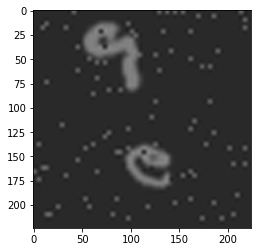

In [ ]:
plt.imshow(tf.image.grayscale_to_rgb(tf.constant(upscaled_img)))

**Denoise after upscaling**

In [ ]:
denoised_upscaled_img = denoise_img(upscaled_img,224)

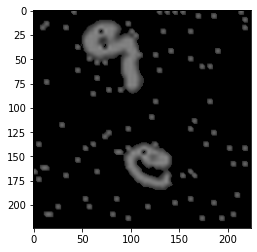

In [ ]:
plt.imshow(tf.image.grayscale_to_rgb(tf.constant(denoised_upscaled_img)))

**The algorithm doesn't work well with upscaled images, so let's try denoising then upscaling**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


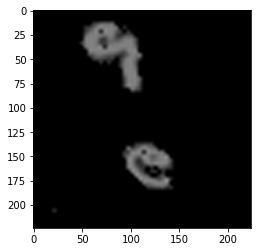

In [ ]:
image = train_data[0]
denoised_img = denoise_img(image,56, reshape=False)
upscaled_denoised_img = cv2.resize(denoised_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
upscaled_denoised_img = upscaled_denoised_img.reshape(upscaled_denoised_img.shape + (1,))
plt.imshow(tf.image.grayscale_to_rgb(tf.constant(upscaled_denoised_img)))

**This works better, but the image is not as clear as the 56*56 sized image, so let's see if this will improve or damage the accuracy of the model**

### Run VGG16
This works only with 224*244 images

In [ ]:
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import random

In [ ]:
# input

def VGG16_Model():
  input = Input(shape =(224,224,1))

  # Numbers
  # 1st Conv Block

  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(input)
  x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
  # 2nd Conv Block

  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
  # 3rd Conv block

  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
  # 4th Conv block

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)

  # 5th Conv block

  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
  x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
  # Fully connected layers

  x = Flatten()(x)
  x = Dense(units = 4096, activation ='relu')(x)
  x = Dense(units = 4096, activation ='relu')(x)
  output = Dense(units = 36, activation ='softmax')(x)
  #num_output = Dense(units = 10, activation ='softmax')(x)

  model = Model (inputs=input, outputs=output)
  return model


In [ ]:
vgg16_model=VGG16_Model()
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 112, 112, 128)     147584    
                                                           

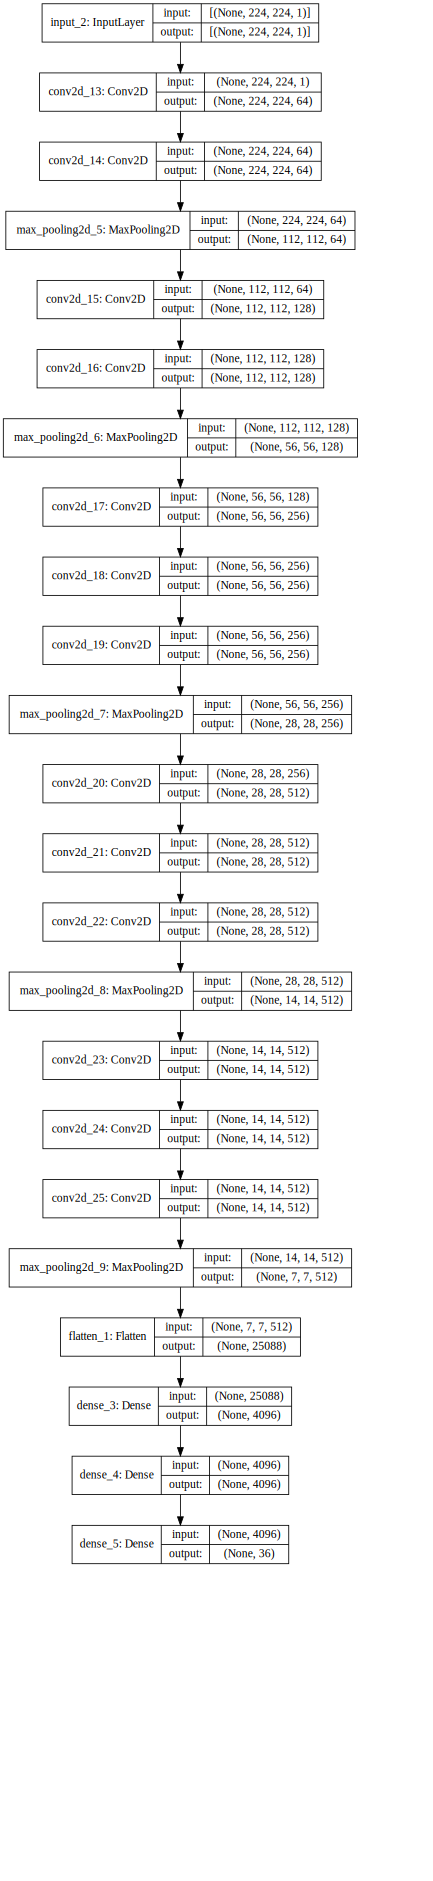

In [ ]:
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pydot
import graphviz

SVG(model_to_dot(vgg16_model, show_shapes=True, show_layer_names=True, rankdir='TB',expand_nested=False, dpi=60, subgraph=False).create(prog='dot',format='svg'))

In [ ]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
epochs=1
batch_size=64
random.seed(1)
N=len(trainX)
val_N = len(valX)
index_list = np.random.permutation(val_N)
batches = np.array_split(np.random.permutation(N), int(N/batch_size))
for epoch in range(epochs):
  print("\n CURRENT EPOCH:{}\n".format(epoch))
  for batch_index, batch in enumerate(batches):
    print("BATCH:{}/{}".format(batch_index, N/batch_size))
    X_tmp = [trainX[i] for i in batch]
    y = np.array([trainY[i] for i in batch])
    val_index_list = np.random.permutation(val_N)
    X_val_tmp = [valX[i] for i in np.random.choice(index_list, batch_size, replace=False)]
    Y_val = np.array([valY[i] for i in np.random.choice(index_list, batch_size, replace=False)])

    # denoise and upscale
    X=[]
    X_val=[]
    for i in range(batch_size):
      image = X_tmp[i]
      denoised_img = denoise_img(image,56, reshape=False)
      upscaled_denoised_img = cv2.resize(denoised_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      upscaled_denoised_img = upscaled_denoised_img.reshape(upscaled_denoised_img.shape + (1,))
      X.append(upscaled_denoised_img)

      image = X_val_tmp[i]
      denoised_img = denoise_img(image,56, reshape=False)
      upscaled_denoised_img = cv2.resize(denoised_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
      upscaled_denoised_img = upscaled_denoised_img.reshape(upscaled_denoised_img.shape + (1,))
      X_val.append(upscaled_denoised_img)

    X = np.asanyarray(X, dtype='float64')
    X_val = np.asanyarray(X_val, dtype='float64')

    vgg16_history = vgg16_model.fit(
        y,
        validation_data=(X_val, Y_val),
        epochs=1,
        batch_size=batch_size
    )

## Initial models

#### Model 2

In [ ]:
def make_model_2():   
  inputs = Input(shape=IMAGE_SIZE + (1,), name='input_layer')

  preprocessing = preprocess(inputs)

  numbers = Conv2D(32, 5, activation='relu', padding='same')(preprocessing)
  numbers = Conv2D(32, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(24, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(20, 3, activation='relu')(numbers)
  numbers = Flatten()(numbers)
  numbers = Dropout(0.4)(numbers)
  numbers = Dense(128, activation='relu')(numbers)
  numbers = Dense(50, activation='relu')(numbers)
  numbers_output = Dense(10, activation='softmax', name='number')(numbers)

  letters = Conv2D(32, 5, activation='relu', padding='same')(preprocessing)
  letters = Conv2D(32, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(24, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(20, 3, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Flatten()(letters)
  letters = Dropout(0.4)(letters)
  letters = Dense(128, activation='relu')(letters)
  letters = Dense(50, activation='relu')(letters)
  letters_output = Dense(26, activation='softmax', name='letter')(letters)

  output = tf.keras.layers.Concatenate()([numbers_output, letters_output])
  return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
test_model = make_model_2()
test_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 56, 56, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 1)  0           ['input_layer[0][0]']            
                                                                                                  
 conv2d_6 (Conv2D)              (None, 224, 224, 32  832         ['sequential[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 224, 224, 32  832         ['sequential[0][0]']         

#### Model 3

In [ ]:
def make_model_3():
  data_augmentation = Sequential([
                                preprocessing.RandomFlip('vertical'),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomTranslation(0.2, 0.2)
  ])
   
  inputs = Input(shape=IMAGE_SIZE + (1,), name='input_layer')

  x = data_augmentation(inputs)

  numbers = Conv2D(32, 5, activation='relu', padding='same')(x)
  numbers = Conv2D(32, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(24, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(20, 3, activation='relu')(numbers)
  numbers = Flatten()(numbers)
  numbers = Dropout(0.4)(numbers)
  numbers = Dense(128, activation='relu')(numbers)
  numbers = Dense(50, activation='relu')(numbers)
  numbers_output = Dense(10, activation='softmax', name='number')(numbers)

  letters = Conv2D(32, 5, activation='relu', padding='same')(x)
  letters = Conv2D(32, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(24, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(20, 3, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Flatten()(letters)
  letters = Dropout(0.4)(letters)
  letters = Dense(128, activation='relu')(letters)
  letters = Dense(50, activation='relu')(letters)
  letters_output = Dense(26, activation='softmax', name='letter')(letters)

  output = tf.keras.layers.Concatenate()([numbers_output, letters_output])
  return tf.keras.Model(inputs=inputs, outputs=output)

#### Model 4

In [ ]:
def make_model_4():
  data_augmentation = Sequential([
                                preprocessing.RandomFlip('vertical'),
                                preprocessing.RandomRotation(0.4),
                                preprocessing.RandomZoom(0.4),
                                preprocessing.RandomTranslation(0.4, 0.4)
  ])
   
  inputs = Input(shape=IMAGE_SIZE + (1,), name='input_layer')

  x = data_augmentation(inputs)

  numbers = Conv2D(32, 5, activation='relu', padding='same')(x)
  numbers = Conv2D(32, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(24, 5, activation='relu')(numbers)
  numbers = MaxPool2D()(numbers)
  numbers = Conv2D(20, 3, activation='relu')(numbers)
  numbers = Flatten()(numbers)
  numbers = Dropout(0.4)(numbers)
  numbers = Dense(128, activation='relu')(numbers)
  numbers = Dense(50, activation='relu')(numbers)
  numbers_output = Dense(10, activation='softmax', name='number')(numbers)

  letters = Conv2D(32, 5, activation='relu', padding='same')(x)
  letters = Conv2D(32, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(24, 5, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Conv2D(20, 3, activation='relu')(letters)
  letters = MaxPool2D()(letters)
  letters = Flatten()(letters)
  letters = Dropout(0.4)(letters)
  letters = Dense(128, activation='relu')(letters)
  letters = Dense(50, activation='relu')(letters)
  letters_output = Dense(26, activation='softmax', name='letter')(letters)

  output = tf.keras.layers.Concatenate()([numbers_output, letters_output])
  return tf.keras.Model(inputs=inputs, outputs=output)

#### Run initial model

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3
    )

In [ ]:
submission_2 = make_model_2()

submission_2.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

submission_2_history = submission_2.fit(
    train_data,
    train_labels,
    shuffle=True,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    callbacks=[
               early_stopping
    ]
)

In [ ]:
write_out_preds(predictions_2, 'preds_2')

## Model trained with denoise Images before Training

In [ ]:
# normalize
denoised_train = (denoised_train+np.abs(np.min(denoised_train)))/(np.max(denoised_train)+np.abs(np.min(denoised_train)))

In [ ]:
net = ResNet18()
if torch.cuda.is_available():
    net.cuda()

loss_function = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.95, weight_decay=1e-5)


X_train, X_cv, y_train, y_cv = train_test_split(denoised_train, train_label, test_size = 0.2, random_state = 6996)
X_train = torch.from_numpy(X_train)
X_train = X_train.view(-1,1,56,56).float()
X_cv = torch.from_numpy(X_cv)
X_cv = X_cv.view(-1,1,56,56).float()
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_cv = torch.from_numpy(y_cv).type(torch.LongTensor)


tranform_aug1 = transforms.Compose([transforms.RandomAffine(
    degrees=(-15,0), translate=(0.01, 0.01), fill=0, shear=0.15)])
tranform_aug2 = transforms.Compose([transforms.RandomAffine(
    degrees=(0,15), translate=(0.01, 0.01), fill=0, shear=0.15)])

train_loader = getDataLoader(X_train, y_train, transforms=[None, transform_aug1, transform_aug2])

In [ ]:
tr_l, tst_l, tr_accu, tst_accu = fit_model(net, train_loader=train_loader, val_loader=val_loader, epochs=15)

  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 1/15]  [Training Loss: 0.125] 
[Val Loss: 0.073]  [Val Accuracy: 0.59]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 2/15]  [Training Loss: 0.061] 
[Val Loss: 0.054]  [Val Accuracy: 0.70]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 3/15]  [Training Loss: 0.046] 
[Val Loss: 0.043]  [Val Accuracy: 0.78]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 4/15]  [Training Loss: 0.040] 
[Val Loss: 0.037]  [Val Accuracy: 0.81]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 5/15]  [Training Loss: 0.036] 
[Val Loss: 0.036]  [Val Accuracy: 0.81]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 6/15]  [Training Loss: 0.033] 
[Val Loss: 0.036]  [Val Accuracy: 0.82]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 7/15]  [Training Loss: 0.032] 
[Val Loss: 0.037]  [Val Accuracy: 0.81]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 8/15]  [Training Loss: 0.030] 
[Val Loss: 0.033]  [Val Accuracy: 0.84]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 9/15]  [Training Loss: 0.030] 
[Val Loss: 0.032]  [Val Accuracy: 0.84]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 10/15]  [Training Loss: 0.029] 
[Val Loss: 0.031]  [Val Accuracy: 0.84]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 11/15]  [Training Loss: 0.028] 
[Val Loss: 0.034]  [Val Accuracy: 0.82]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 12/15]  [Training Loss: 0.027] 
[Val Loss: 0.030]  [Val Accuracy: 0.85]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 13/15]  [Training Loss: 0.027] 
[Val Loss: 0.030]  [Val Accuracy: 0.85]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 14/15]  [Training Loss: 0.027] 
[Val Loss: 0.031]  [Val Accuracy: 0.84]


  0%|          | 0/1125 [00:00<?, ?it/s]

[Epoch: 15/15]  [Training Loss: 0.027] 
[Val Loss: 0.032]  [Val Accuracy: 0.84]


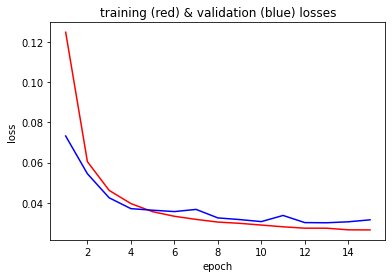

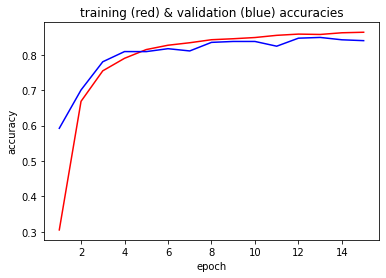

In [ ]:
plot(tr_l, tst_l, tr_accu, tst_accu)